# Multi Location

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from typing import Callable, List

import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

2024-10-29 17:37:37.770917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 17:37:37.897492: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from models.handnet_based_model import handnet_based_model
from util.training import init_device
from util.training.dataloader import split_data_for_multiple_location
from util.training.metrics import IntersectionOverUnion, MeanPixelAccuracy

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


# 準備
---

## デバイスの初期化

In [5]:
!nvidia-smi

Tue Oct 29 17:37:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:18:00.0 Off |                  Off |
| 30%   25C    P8    17W / 300W |     28MiB / 48682MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:3B:00.0 Off |                  Off |
| 30%   

In [6]:
# 使用するGPUを指定
gpu = [3]

In [7]:
seed = 42
init_device(seed, gpu)

Setting random seed: 42
Random seed set for Python, NumPy, and TensorFlow.
Detected 5 GPU(s): ['/physical_device:GPU:0', '/physical_device:GPU:1', '/physical_device:GPU:2', '/physical_device:GPU:3', '/physical_device:GPU:4']
Visible GPU devices (1): ['/physical_device:GPU:3']


## ハイパーパラメータクラスの定義

In [8]:
@dataclass
class HyperParameters:
    epochs: int
    batch_size: int
    loss_function: Callable
    metrics: List[Callable]
    optimizer: Callable

## モデルの初期化関数の定義

In [9]:
def init_model(hparam):
    model = handnet_based_model(
        input_shape = (10, 52, 2),
        num_block1 = 3,
        num_block2 = 3,
        num_residual_blocks = 14, # 残差ブロックは増やすと重くなる
    )
    
    model.compile(
        optimizer = hparam.optimizer,
        loss = hparam.loss_function,
        metrics = hparam.metrics,
    )

    return model

## コールバック準備関数の定義

In [10]:
def prepare_callbacks(hparam, log_dirpath):

    callbacks = [
        TensorBoard(log_dir=log_dirpath, histogram_freq=1),
        EarlyStopping(
            monitor='val_iou',
            mode='max',
            patience=10,
            restore_best_weights=True,
        )
    ]

    return callbacks

## モデルを訓練する関数の定義

In [11]:
def train(hparam, dataset, log_dirpath):
    print(f'log_dir = {log_dirpath}')

    # データの用意
    train_data, valid_data, test_data = dataset
    X_train, Y_train = train_data
    X_valid, Y_valid = valid_data
    X_test, Y_test = test_data

    # モデルを作成
    model = init_model(hparam)

    # モデルのフィッティング
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_valid, Y_valid),
        epochs = hparam.epochs,
        batch_size = hparam.batch_size,
        verbose = 1,
        callbacks = prepare_callbacks(hparam, log_dirpath)
    )

    # テストデータでの評価
    test_loss, *test_metric = model.evaluate(X_test, Y_test, verbose=2)
    print(f"Test Loss: {test_loss}, Test Metric: {test_metric}")

    return history, model

# モデルの訓練
---

In [12]:
def get_log_dirpath(root_log_dirpath, notebook_name):
    date = datetime.now().strftime("%Y-%m-%d")
    time = datetime.now().strftime("%H-%M-%S")
    log_dirpath = os.path.join(
        root_log_dirpath, 
        date,
        notebook_name,
        time
    )

    return log_dirpath

In [13]:
# データをロード
csi_preprocess_id = 'real_and_imag'
location_list = ['511', '512', '514B']
dataset, dataset_dict = split_data_for_multiple_location(csi_preprocess_id, location_list)

# ハイパーパラメータの指定
hparam = HyperParameters(
    epochs = 150,
    batch_size = 64,
    optimizer = Adam(learning_rate=0.001),
    loss_function = BinaryFocalCrossentropy(gamma=2), # BinaryCrossentropy(),
    metrics = [IntersectionOverUnion(threshold=0.5), MeanPixelAccuracy()],
)

# ログディレクトリを指定
project_dirpath = Path('/tf/workspace/deformation-prediction-multi-environment')
root_log_dirpath = project_dirpath/'logs' 
notebook_name = f'multi_location_real_and_imag'
log_dirpath = get_log_dirpath(root_log_dirpath, notebook_name)

history, model = train(hparam, dataset, log_dirpath)

2024-10-29 17:37:58.101078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 17:37:58.668451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46258 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


log_dir = /tf/workspace/deformation-prediction-multi-environment/logs/2024-10-29/multi_location_real_and_imag/17-37-59
Epoch 1/150


2024-10-29 17:38:21.222138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-10-29 17:38:22.950447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-29 17:38:23.175564: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6c8c0177c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-29 17:38:23.175602: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-10-29 17:38:23.183725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 17:38:23.343028: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

394/394 [==============================] - 87s 109ms/step - loss: 0.0960 - iou: 0.2343 - mpa: 0.6150 - val_loss: 0.0962 - val_iou: 0.2413 - val_mpa: 0.6188
Epoch 2/150
394/394 [==============================] - 41s 105ms/step - loss: 0.0914 - iou: 0.2620 - mpa: 0.6298 - val_loss: 0.1017 - val_iou: 0.2512 - val_mpa: 0.6214
Epoch 3/150
394/394 [==============================] - 42s 106ms/step - loss: 0.0889 - iou: 0.2946 - mpa: 0.6470 - val_loss: 0.1010 - val_iou: 0.2885 - val_mpa: 0.6438
Epoch 4/150
394/394 [==============================] - 42s 107ms/step - loss: 0.0868 - iou: 0.3295 - mpa: 0.6655 - val_loss: 0.1055 - val_iou: 0.2923 - val_mpa: 0.6434
Epoch 5/150
394/394 [==============================] - 42s 105ms/step - loss: 0.0844 - iou: 0.3619 - mpa: 0.6826 - val_loss: 0.1130 - val_iou: 0.3011 - val_mpa: 0.6476
Epoch 6/150
394/394 [==============================] - 42s 106ms/step - loss: 0.0815 - iou: 0.3996 - mpa: 0.7026 - val_loss: 0.1066 - val_iou: 0.3243 - val_mpa: 0.6618
Epoc

# ファインチューニング

# 評価
---

In [26]:
_, valid_data, test_data_dict = dataset
X_valid, Y_valid = valid_data
X_test, Y_test = test_data_dict['514B']

## 各メトリックの平均値

In [27]:
results = model.evaluate(X_test, Y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.04f}")

57/57 [==============================] - 2s 32ms/step - loss: 0.1130 - iou: 0.3241 - mpa: 0.6610
loss: 0.1130
iou: 0.3241
mpa: 0.6610


# 予測結果のサンプルをランダムに表示

In [17]:
from util.plot import plot_predictions

In [18]:
metrics = {'IoU': IntersectionOverUnion(threshold=0.5), 'mPA': MeanPixelAccuracy()}

169/169 [==============================] - 5s 22ms/step


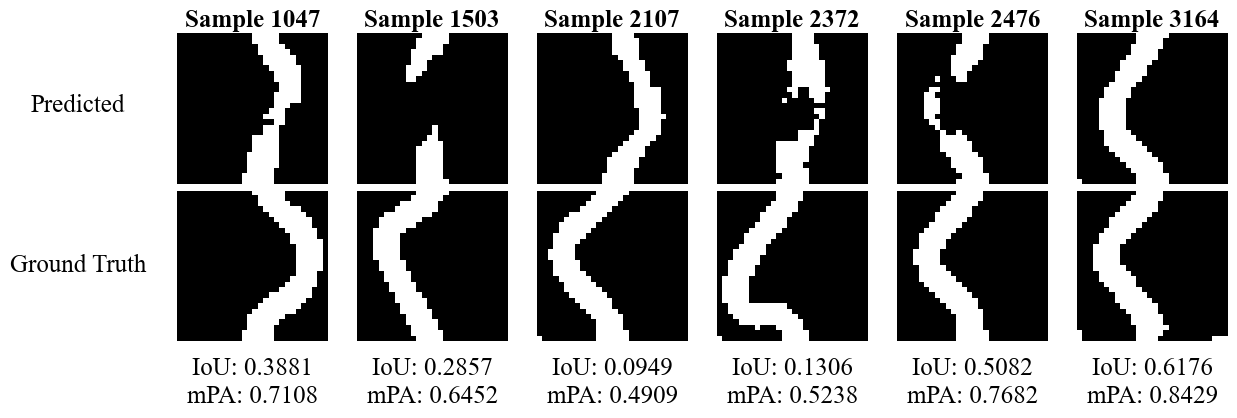

In [19]:
# 検証セット
plot_predictions(model, X_valid, Y_valid, n_samples=6, threshold=0.5, seed=42, metrics=metrics)

57/57 [==============================] - 2s 27ms/step


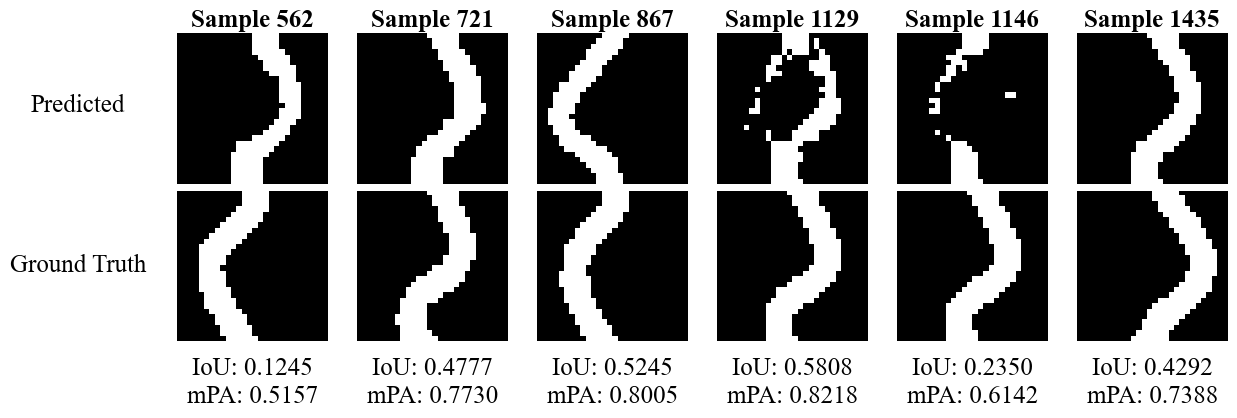

In [29]:
# テストセット
plot_predictions(model, X_test, Y_test, n_samples=6, threshold=0.5, seed=44, metrics=metrics)

環境依存性  
Loss関数による性能の違い